# PAM Modulated OFDM Signal Generation

In [2186]:
import numpy as np
import matplotlib.pyplot as plt

In [2188]:
N = 6000 # number of bits per pseudonym bit
mod_index = 0.1 # decides the level of modification/modulation on the host signal

In [2189]:
def OFDM_TX(x):
    #args = parse_args()
    K = 64 # number of OFDM subcarriers
    P = 4 # number of pilot carriers per OFDM block
    G = 12 # number of guard carriers
    CP = 16  # 25% Cyclic Prefix 
    M = 2 # bits per symbol (i.e. QPSK)
    
    # generate the host message signal
    bits = np.random.binomial(n=1, p=0.5, size=(x*9600,))
    dataCarriers = np.array([-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,
                         -5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
    pilotCarriers = np.array([-21,-7,7,21])
    guardCarriers = np.array([-32,-31,-30,-29,-28,-27,26,27,28,29,30,31])
 
    for i in range(len(bits)//(2*K)):
        
        data_bits = bits[i*2*K:(i+1)*2*K]

        # Convert serial data to parallel
        def Serial_to_Parallel(x):
            return x.reshape((K, M))
        parallel_bits = Serial_to_Parallel(data_bits)

        # mapping table
        ## maps data_bits into complex value IQ samples
        mapping_table = {
            (0,0) : 1.4142 + 1.4142j,
            (0,1) : -1.4142 + 1.4142j,
            (1,0) : 1.4142 - 1.4142j,
            (1,1) : -1.4142 - 1.4142j
        }

        # mapping
        def Mapping(x):
            return np.array([mapping_table[tuple(b)] for b in x])
        
        QPSK = Mapping(parallel_bits)

        # OFDM symbol generation
        def OFDM_symbol_gen(x):
            #pilot_value = np.array([1.5+1.5j, -1.5-1.5j, 1.5+1.5j, -1.5-1.5j])
            guard_band = np.array([0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j])
            
            symbol = np.zeros(K, dtype=np.complex64)
            symbol[dataCarriers] = x[dataCarriers]
            #symbol[pilotCarriers] = pilot_value
            symbol[guardCarriers] = guard_band
            return symbol
        OFDM_symbol = OFDM_symbol_gen(QPSK)
        
        # Generate time domain signal
        def IDFT(x, n=64):
            return np.fft.ifftshift(np.fft.ifft(x,n))
        
        OFDM_symbol_time = IDFT(OFDM_symbol)

        # adding cyclic prefix samples
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = addCP(OFDM_symbol_time)
        #OFDM_withCP = addCP(OFDM_symbol)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP]) # append data
            OFDM_swap = OFDM_signal
    return OFDM_signal

In [2190]:
## embedding the pseudonym message signal on to the host data signal
## N OFDM samples are multiplied by a higher or lower constant depending on the pseudonym bit sequence.
def Pseudonym_embedding(x,message):
    modulated_signal = np.zeros(len(x), dtype=np.complex64)
    for i in range(int(len(x)/N)):
        if message[i] == 1.0:
            modulated_signal[i*N:(i+1)*N] = (1+mod_index)*x[i*N:(i+1)*N]
        else:
            modulated_signal[i*N:(i+1)*N] = (1-mod_index)*x[i*N:(i+1)*N] 
    return modulated_signal

In [ ]:
# Converts text into bits where one character is represented by 7 bits
def text2bits(message):
    # Convert to characters of '1' and '0' in a vector.
    temp_message = []
    final_message = []
    for each in message:
        temp_message.append(format(ord(each), '07b'))
    for every in temp_message:
        for digit in every:
            final_message.append(int(digit))
    return final_message

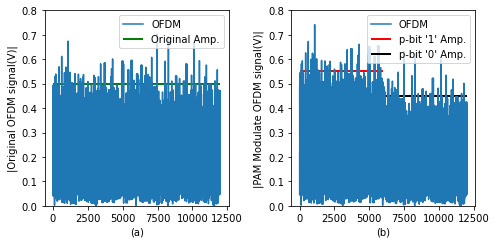

In [2191]:
##########################################################################
# Generate PAM modulated OFDM signal 
##########################################################################

pseudonym_message = 'STOP'
OFDM_signal = OFDM_TX(len(text2bits(pseudonym_message)))
PAM_modulated_OFDM = Pseudonym_embedding(OFDM_signal,text2bits(pseudonym_message))

# plot of the PAM modulated signal
# plots are for the first 12000 OFDM samples
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abs(OFDM_signal[12000:2*12000]))
ax1.set_ylim([0,0.8])
plt.hlines(y = .5, color = 'green', xmin = 0, xmax = 12000, linewidth =2)
plt.ylabel('|Original OFDM signal(V)|')
plt.xlabel('(a)')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(abs(PAM_modulated_OFDM[12000:2*12000]), label ="b")
ax2.set_ylim([0,0.8])
plt.hlines(y = .55, color = 'red', xmin = 0, xmax = 6000, linewidth =2)
plt.hlines(y = .45, color = 'black', xmin = 6000, xmax = 12000, linewidth =2)
plt.ylabel('|PAM Modulate OFDM signal(V)|')
plt.xlabel('(b)')

ax1.legend(("OFDM","Original Amp."), loc = "upper right")
ax2.legend(("OFDM","p-bit '1' Amp.","p-bit '0' Amp."), loc = "upper right")
plt.tight_layout()
plt.show()

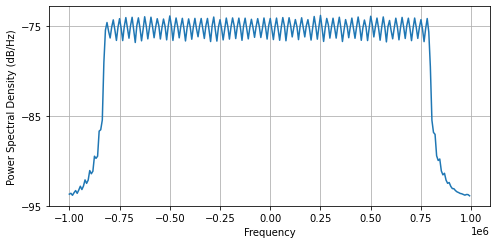

In [2194]:
# The PAM modulated OFDM signal in frequency domain
plt.psd(PAM_modulated_OFDM, Fs = 2e6)#, Fc = 3655e6)
plt.show()

## Add preamble for synchronization
## Preamble generation is forked from: https://github.com/npatwari/tx_rx_processing/tree/main

In [2195]:
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
    
    return (s_0_I + 1j*s_0_Q)

In [2196]:
# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    log2M   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

In [2197]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [2198]:
# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

In [2199]:
# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

In [2200]:
A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6
preambleSignal = createPreambleSignal(A, N, alpha, Lp)

352

In [2201]:
PAM_Modulated_OFDM_with_preamb = np.hstack([preambleSignal,PAM_modulated_OFDM])

## Convert complex into binary for transmission over GNU radio

In [2203]:
# Converts complex to floating point numbers
# filename is the file data for transmission using one of the SDRs nodes running GNU radio
def write_complex_binary(data, filename):
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float 
    INPUT
    ----
    data:     data to be writen into the file. format: (length, )
    filename: file name
    '''
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)   
write_complex_binary(PAM_Modulated_OFDM_with_preamb, 'OFDM_signal_m02.iq')